## Mintclassics Analysis with Python

This notebook presents a data-driven evaluation of warehouse performance for Mint Classics, aimed at identifying opportunities for warehouse consolidation and inventory optimization.
Data was extracted from the company's MySQL database, then imported and analyzed using Python.

The analysis covers:

- Revenue contributions by warehouse

- Delivery time performance across warehouses

- Stock utilization and understocked/overstocked product detection

- Statistical testing to assess warehouse-level differences

This comprehensive evaluation supports evidence-based decisions around inventory rearrangement and warehouse consolidation.

#### Import packages 

In [4]:
# Import libraries and packages 
import pandas as pd
import seaborn as sns
import numpy as np
import os
from scipy.stats import levene
from scipy.stats import kruskal
import scikit_posthocs as sp
import scipy.stats as stats
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd


#### Capacity Utilization by warehouse 


 This section analyzes the physical capacity currently utilized by each warehouse. The summary table illustrates the percentage of capacity used up by each warehouse 

In [138]:
df0 = pd.read_csv("../Data/warehouse_utilization_result.csv")
df0

,warehouseCode,warehouseName,warehousePctCap
0,a,North,72
1,b,East,67
2,c,West,50
3,d,South,75


Capacity utilization varies notably across the warehouse network. Warehouses West (C) and East (B) show substantial unused capacity, while North (A) and South (D) operate closer to their limits. This distribution indicates that consolidating the West warehouse’s inventory into the remaining facilities could be achieved without exceeding their capacity. Furthermore, when viewed alongside other operational metrics, the West also emerges as a strong candidate to absorb additional inventory from any warehouse selected for consolidation.

#### Revenue Contribution by warehouse

This section provides a comparative analysis of monthly revenue performance across Mint Classics' distribution warehouses. Leveraging transaction-level data aggregated by `order_month` and `warehouseCode`,revenue trends were evaluated to uncover disparities in warehouse contribution.

In [154]:
# load data 
df = pd.read_csv("../Data/monthly_revenue.csv")

In [8]:
# Inspect first 5 rows of the dataset
df.head()

,order_month,warehouseCode,monthly_revenue
0,2003-01,a,0.00
1,2003-01,b,36552.33
2,2003-01,c,40950.66
3,2003-01,d,39189.78
4,2003-02,a,59428.89


In [9]:
# Obtain counts of rows and columns 
df.shape

(116, 3)

Prior to statistical inference, diagnostic checks were conducted to confirm underlying assumptions of normality and variance homogeneity.

Text(0.5, 1.0, 'Monthly Revenue Distribution by Warehouse')

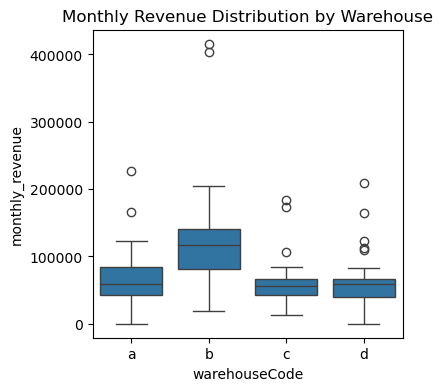

In [11]:
# Create boxplot to show distribution of monthly_revenue by warehouse
plt.figure(figsize=(4,4))
sns.boxplot(x = "warehouseCode", y = "monthly_revenue", data = df)
plt.title("Monthly Revenue Distribution by Warehouse")


##### Levene's test for homogenuity of variances 

This test checks whether the variance of `monthly_revenue` across warehouses is statistically equal.

- Null hypothesis $H_0$,  The variances of `monthly_revenue` are equal across all the `warehouseCode` groups. 
- Alternative hypothesis $H_1$, At least one `warehouseCode` group has a significantly different variance of `monthly_revenue`.
- Significance Level (α): **0.05**

In [14]:
# group by dataframe by warehousecode
grouped_data = [group["monthly_revenue"].values for name, group in df.groupby("warehouseCode")]

# Levene's test
stat, p = levene(*grouped_data)

print("Levene's test p-value:", p)
if p < 0.05:
    print("❌ Variances are significantly different.")
else:
    print("✅ Variances are equal — assumption met.")

Levene's test p-value: 0.0328851314590923
❌ Variances are significantly different.


Since the p-value (0.032885) is less than the chosen significance level (α=0.05), we reject the null hypothesis ($H_0$
​
 ). This indicates that there is statistically significant evidence to conclude that the variances of `monthly_revenue` are not equal across the different warehouses.

 The violation of the homogeneity of variances assumption means that a standard One-Way ANOVA is not appropriate for comparing the means of `monthly_revenue` between warehouses. Therefore, we proceeded with a robust alternative that does not require this assumption.

##### Kruskal-Wallis H-Test 

Given the rejection of the null hypothesis for homogeneity of variances, we opted for Kruskal-Wallis H-test to compare the median `monthly_revenue` across the warehouses. This test is robust to unequal variances, and does not assume normality of the data providing a more reliable assessment of group differences under these conditions.

- Null hypothesis $H_0$,  The population median `monthly_revenue` are equal across all the `warehouseCode` groups. 
- Alternative hypothesis $H_1$, At least one `warehouseCode` group has a significantly different  population median of `monthly_revenue`.
- Significance Level (α): **0.05**

In [18]:
# Group revenue values per warehouse
grouped_data = [group["monthly_revenue"].values for _, group in df.groupby("warehouseCode")]

# Kruskal-Wallis test
stat, p = kruskal(*grouped_data)
print("Kruskal-Wallis p-value:", p)

Kruskal-Wallis p-value: 9.585494655167861e-05


Based on the Kruskal-Wallis H-test, with a p-value of 0.00009585 (which is far less than α=0.05), we reject the null hypothesis $H_0$. This implies there is strong statistical evidence to conclude that at least one warehouse has a significantly different population median monthly_revenue compared to the others.

Post-hoc tests are carried out to investigate the pairwise relationships between the warehouses 

##### Pairwise Dunn's test

Following the significant result from the Kruskal-Wallis H-test, Dunn's post-hoc pairwise comparisons were conducted to identify which specific warehouse pairs exhibited statistically significant differences in their population median monthly_revenue. A significance level of 
alpha=0.05 was used for these comparisons

In [21]:
# Dunn’s test with Bonferroni correction
sp.posthoc_dunn(df, val_col='monthly_revenue', group_col='warehouseCode', p_adjust='bonferroni')

,a,b,c,d
a,1.000000,0.006278,1.000000,1.000000
b,0.006278,1.000000,0.000498,0.000544
c,1.000000,0.000498,1.000000,1.000000
d,1.000000,0.000544,1.000000,1.000000


In [22]:
#obtain medians across warehouses 
df.groupby("warehouseCode")["monthly_revenue"].median().sort_values()

warehouseCode
c     55499.83
d     58439.14
a     59428.89
b    116763.05
Name: monthly_revenue, dtype: float64

The pairwise comparisons reveal that Warehouse B (West) exhibits a statistically significant difference in its monthly_revenue pattern when compared to Warehouses A, C, and D. Further inspection of the warehouse medians confirms that Warehouse B (West) contributes the highest median monthly_revenue. This robust performance makes Warehouse B a strong candidate for retention rather than consolidation based on revenue generated . Conversely, as Warehouses A, C, and D show no significant differences in their median monthly_revenue, their suitability for consolidation should be primarily determined by an evaluation of other critical performance metrics.




  


#### Delivery Performance Analysis

This section assesses the delivery efficiency of Mint Classics' warehouses by analyzing delivery times across fulfillment locations. Timely deliveries are critical to customer satisfaction and operational excellence, making this metric a key input in warehouse consolidation decisions. The objective is to identify which warehouses consistently meet or exceed delivery expectations and which ones underperform, thereby informing decisions about which facilities may be retained or consolidated. 

The necessary delivery data was extracted directly from the database through carefully structured joins across relevant tables, including `orders`, `orderdetails`, and `products`. A new key performance indicator, 'delivery margin', was specifically derived for this analysis. This metric quantifies the number of days a delivery was completed relative to the required delivery date (e.g., a positive value indicates delivery before the required date, while a negative value signifies a delay). This `delivery margin` metric serves as the foundational basis for comparing delivery performance across all warehouses.


In [26]:
#load dataset 
df1 = pd.read_csv("../Data/delivery_analysis.csv")

In [27]:
#inspect first 5 rows of the dataset 
df1.head()

,orderNumber,warehouseCode,shippedDate,requiredDate,orderDate,delivery_margin_days
0,10100,c,2003-01-10,2003-01-13,2003-01-06,3
1,10100,c,2003-01-10,2003-01-13,2003-01-06,3
2,10100,c,2003-01-10,2003-01-13,2003-01-06,3
3,10100,c,2003-01-10,2003-01-13,2003-01-06,3
4,10101,c,2003-01-11,2003-01-18,2003-01-09,7


In [28]:
df1.shape

(2855, 6)

<Axes: xlabel='warehouseCode', ylabel='delivery_margin_days'>

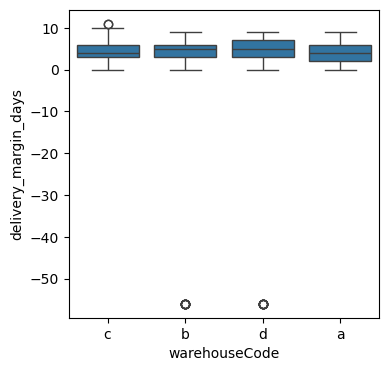

In [29]:
# create boxplot to show distribution of delivery_margin across warehouses
plt.figure(figsize=(4,4))
sns.boxplot(x = "warehouseCode", y = "delivery_margin_days", data = df1)






The box plot helped identify a small cluster of outliers representing orders with delays exceeding 50 days. To determine the root cause of these anomalies, a direct query of the orders table was conducted, focusing on orderNumber, orderDate, status, and comments. This investigation revealed that all such outlier orders originated from a single customer on a specific date, with an associated comment indicating customer credit limit issues as the primary cause, rather than logistical or operational delays. As a result, these orders were excluded from the delivery efficiency analysis to prevent distortion and ensure the focus remained on evaluating warehouse logistics performance.




In [31]:
## filter out outliers 
outliers = df1[df1['orderNumber'] == 10165]
df1_filtered = df1[df1['orderNumber'] != 10165]


In [32]:
#inspect new dataframe
df1_filtered.head()

,orderNumber,warehouseCode,shippedDate,requiredDate,orderDate,delivery_margin_days
0,10100,c,2003-01-10,2003-01-13,2003-01-06,3
1,10100,c,2003-01-10,2003-01-13,2003-01-06,3
2,10100,c,2003-01-10,2003-01-13,2003-01-06,3
3,10100,c,2003-01-10,2003-01-13,2003-01-06,3
4,10101,c,2003-01-11,2003-01-18,2003-01-09,7


In [33]:
df1_filtered.shape

(2837, 6)

In [34]:
#obtain mean delivery_margin_days across warehouses
df1_filtered.groupby("warehouseCode")["delivery_margin_days"].mean().sort_values()

warehouseCode
a    4.181278
c    4.626214
b    4.820248
d    4.842561
Name: delivery_margin_days, dtype: float64

Again tests are carried out to check if underlying assumptions of normality and variance homogeneity are met.

##### Levene's test for homogenuity of variances 

This test checks whether the variance of `delivery_margin_days` across warehouses is statistically equal.

- Null hypothesis $H_0$,  The variances of `delivery_margin_days` are equal across all the `warehouseCode` groups. 
- Alternative hypothesis $H_1$, At least one `warehouseCode` group has a significantly different variance of `delivery_margin_days`.
- Significance Level (α): **0.05**

In [38]:
#group data
grouped_data = [group["delivery_margin_days"].values for name, group in df1_filtered.groupby("warehouseCode")]

# Levene's test
stat, p = levene(*grouped_data)

print("Levene's test p-value:", p)
if p < 0.05:
    print("❌ Variances are significantly different.")
else:
    print("✅ Variances are equal — assumption met.")

Levene's test p-value: 0.11709300610120393
✅ Variances are equal — assumption met.


Since the p-value (0.117093) is greater than our chosen significance level (α=0.05), we fail to reject the null hypothesis ($H_0$,). This indicates that there is no statistically significant evidence to suggest that the variances of delivery performance are different across the warehouses. Therefore, the assumption of homogeneity of variances is considered met.

Since the assumption of homogeneity of variances was met, the next step in validating the suitability of a standard ANOVA was to assess the normality of the residuals. A Q-Q plot was produced from the ANOVA model to visually inspect their distribution.

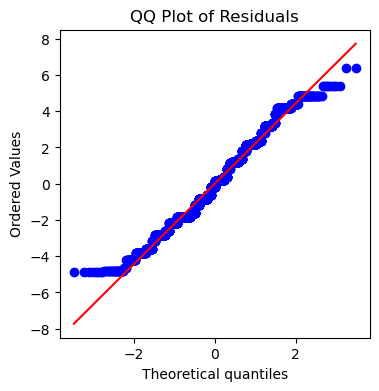

In [41]:
# Construct a simple linear regression model, and fit the model
model = ols('delivery_margin_days ~ C(warehouseCode)', data=df1_filtered).fit()

# Plot QQ-plot
plt.figure(figsize=(4,4))
stats.probplot(model.resid, dist="norm", plot=plt)
plt.title("QQ Plot of Residuals")
plt.show()

Most of the points fall along the red line, especially around the center (quantiles near 0), which indicates that the residuals approximately follow a normal distribution. Although there is some deviation at the tails, the residuals are close enough to normal to meet the normality assumption for ANOVA testing.

##### One-way ANOVA


- Null hypothesis $H_0$,  The population means of `delievery_margin_days` are equal across all the `warehouseCode` groups.
- Alternative hypothesis $H_1$, At least one warehouseCode group has a significantly different population mean of `delivery_margin_days`.
- Significance Level (α): **0.05**

In [44]:
# Run one-way ANOVA
sm.stats.anova_lm(model, typ = 2)


,sum_sq,df,F,PR(>F)
C(warehouseCode),196.667158,3.0,13.169777,1.541431e-08
Residual,14101.935592,2833.0,NaN,NaN


The observed p-value from the ANOVA was highly significant, leading to the rejection of the null hypothesis. This confirms that the mean delivery_margin_days is significantly different across various warehouseCode groups. As a result, post-hoc tests will be performed to explore the pairwise relationships and identify which specific warehouse pairs have statistically significant differences in their mean delivery performance.

##### Tukey's HSD (honestly significantly different) test.

Following the statistically significant result from the One-Way ANOVA, Tukey's Honestly Significant Difference (HSD) post-hoc test was conducted to further examine the pairwise relationships between the warehouses. The goal of this post-hoc analysis is to determine exactly which specific warehouse pairs show statistically significant differences in their population mean delivery_margin_days. A significance level of α=0.05 was used for these comparisons.

In [48]:
# Run Tukey's HSD post hoc test for one-way ANOVA
tukey_oneway = pairwise_tukeyhsd(endog = df1_filtered["delivery_margin_days"], groups = df1_filtered["warehouseCode"])

# Display the results
tukey_oneway.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
a,b,0.639,0.0,0.3511,0.9268,True
a,c,0.4449,0.002,0.1254,0.7645,True
a,d,0.6613,0.0,0.336,0.9865,True
b,c,-0.194,0.3296,-0.4893,0.1013,False
b,d,0.0223,0.9976,-0.2792,0.3238,False
c,d,0.2163,0.3367,-0.1155,0.5482,False


**Test 1:A vs B**

$H_0: \mu_A = \mu_B$

The population mean delivery_margin_days for Warehouse A is equal to that for Warehouse B 

$H_1: \mu_A \neq \mu_B$

The population mean delivery_margin_days for Warehouse A is not equal to that for Warehouse B

Result: We reject the null hypothesis that the population mean delivery_margin_days for Warehouse A is equal to that for Warehouse B 



**Test 2:A vs C**

$H_0: \mu_A = \mu_C$

The population mean delivery_margin_days for Warehouse A is equal to that for Warehouse C 

$H_1: \mu_A \neq \mu_C$

The population mean delivery_margin_days for Warehouse A is not equal to that for Warehouse C

Result: We reject the null hypothesis that the population mean delivery_margin_days for Warehouse A is equal to that for Warehouse B 


**Test 3:A vs D**

$H_0: \mu_A = \mu_D$

The population mean delivery_margin_days for Warehouse A is equal to that for Warehouse D 

$H_1: \mu_A \neq \mu_D$

The population mean delivery_margin_days for Warehouse A is not equal to that for Warehouse D

Result: We reject the null hypothesis that the population mean delivery_margin_days for Warehouse A is equal to that for Warehouse D


**Test 4:B vs C**

$H_0: \mu_B = \mu_C$

The population mean delivery_margin_days for Warehouse B is equal to that for Warehouse C 

$H_1: \mu_B \neq \mu_C$

The population mean delivery_margin_days for Warehouse B is not equal to that for Warehouse C

Result: We fail to reject the null hypothesis that the population mean delivery_margin_days for Warehouse B is equal to that for Warehouse C 

**Test 5:B vs D**

$H_0: \mu_B = \mu_D$

The population mean delivery_margin_days for Warehouse B is equal to that for Warehouse D 

$H_1: \mu_B \neq \mu_D$

The population mean delivery_margin_days for Warehouse B is not equal to that for Warehouse D

Result: We fail to reject the null hypothesis that the population mean delivery_margin_days for Warehouse B is equal to that for Warehouse D

**Test 6:C vs D**

$H_0: \mu_C = \mu_D$

The population mean delivery_margin_days for Warehouse C is equal to that for Warehouse D 

$H_1: \mu_C \neq \mu_D$

The population mean delivery_margin_days for Warehouse C is not equal to that for Warehouse D

Result: We fail to reject the null hypothesis that the population mean delivery_margin_days for Warehouse C is equal to that for Warehouse D 






Tukey's HSD test indicates that Warehouse A demonstrates a statistically significant underperformance in delivery performance compared to Warehouses B, C, and D. This positions Warehouse A as the least efficient facility, consistently delivering later than its counterparts.

Conversely, Warehouses B, C, and D show no statistically significant differences in their mean `delivery_margin_days` among themselves. From a delivery performance perspective, they are statistically interchangeable.

Therefore, when considering consolidation strategies based solely on delivery performance, Warehouse A should be prioritized for review or potential closure, given its demonstrably lower efficiency. The remaining three warehouses (B, C, and D) perform comparably and would require additional criteria beyond delivery performance to determine which should be retained or consolidated

#### Stock Utilization Analysis 

This section aims to identify excess or dead stock, as well as indications of potential understocking, across warehouses by analyzing inventory turnover characteristics. A key performance indicator, the stock utilization ratio, was specifically derived for this analysis. This metric is calculated as the ratio of quantity ordered in the past 12 months for a product to its current quantity in stock (quantity_ordered_last_year / quantityInStock).

The stock utilization ratio provides a crucial insight into how effectively a product's recent demand has consumed its current inventory. A lower ratio indicates that a significant amount of a product's current stock remains unsold despite its recent sales activity, signaling it as potentially slow-moving or, in extreme cases (where quantity_ordered_last_year is zero but quantityInStock is greater than zero), dead stock. Conversely, a high ratio suggests a fast-moving product where recent demand is high relative to current stock, potentially indicating efficient inventory management or, conversely, a risk of understocking. This analysis relies on stock data extracted directly from the database through carefully structured joins across relevant tables, including products, order details, and orders.




In [52]:
#import data
df2 = pd.read_csv("../Data/stock_util.csv")


In [53]:
#inspect first 5 rows
df2.head()

,productCode,productName,quantityInStock,quantity_ordered,warehousecode,buyPrice
0,S18_3232,1992 Ferrari 360 Spider red,8347,914,b,77.90
1,S18_1342,1937 Lincoln Berline,8693,654,c,60.62
2,S18_3856,1941 Chevrolet Special Deluxe Cabriolet,2378,612,c,64.58
3,S50_1341,1930 Buick Marquette Phaeton,7062,592,c,27.06
4,S32_1374,1997 BMW F650 ST,178,591,a,66.92


In [54]:
# derive stock_utilization variable 
df2['stock_utilization_ratio'] = df2['quantity_ordered'] / df2['quantityInStock'].replace(0, pd.NA)
df2['stock_utilization_ratio'] = df2['stock_utilization_ratio'].fillna(0)

In [55]:
df2.shape

(110, 7)

In [56]:
# derive value of inventory
df2['stock_value'] = df2['quantityInStock'] * df2['buyPrice']


<Axes: xlabel='warehousecode', ylabel='stock_utilization_ratio'>

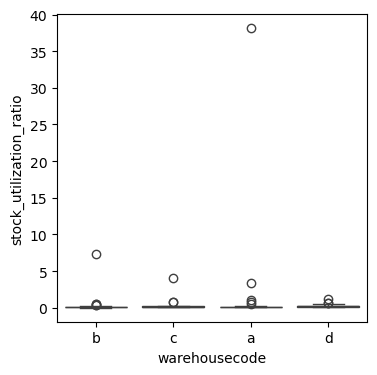

In [57]:
# create boxplot to show distribution of stock_utilization across warehouses
plt.figure(figsize=(4,4))
sns.boxplot(x = "warehousecode", y = "stock_utilization_ratio", data = df2)


The box plot of stock_utilization_ratio highlights an issue of slow-moving or dead stock across all Mint Classics warehouses, with most products exhibiting very low recent utilization. While all warehouses also display outliers indicating fast-moving or potentially understocked items (ratio > 1), these are exceptions. Notably, Warehouse 'a' shows an extreme outlier with a ratio nearing 40. This data reveals a dual inventory challenge: widespread poor turnover alongside specific instances of high-demand items at risk of stock-outs

##### Deadstock Analysis

In [60]:
# Filter products with zero quantity ordered
zero_sales_df = df2[df2['quantity_ordered'] == 0]

# Select relevant columns
zero_sales_df = zero_sales_df[['productCode', 'productName', 'quantityInStock', 'quantity_ordered', 'warehousecode', 'stock_value', ]]

# View or export
print("Products with zero sales in the last year:")
print(zero_sales_df)

Products with zero sales in the last year:
    productCode        productName  quantityInStock  quantity_ordered  \
109    S18_3233  1985 Toyota Supra             7733                 0   

    warehousecode  stock_value  
109             b    440858.33  


This analysis identified only a single product with no recorded sales in the past year, the '1985 Toyota Supra' (Product Code S18_3233), located in Warehouse 'b'. A buy price of  `$57.01` per unit. With a quantity in stock of `7773 units`, this single dead stock item represents a total value of `$440,858` tied down in inventory

This finding indicates that Mint Classics does not face a widespread issue of completely stagnant inventory. However, this specific item represents a direct financial liability and an opportunity for immediate capital recovery through liquidation or other disposition strategies.



##### Slow-Moving and Overstocked Inventory Assessment


For the purpose of identifying overstocked inventory, a quantitative threshold was defined: products falling within or below the 25th percentile of the stock_utilization_ratio were classified as slow-moving or overstocked. This percentile-based methodology offers a flexible and data-driven approach to segmentation. It is important to note that the specific threshold chosen can be refined in future analyses, allowing for alignment with evolving business objectives or strategic inventory management directives from sales and marketing.

In [64]:
#define threshold 
threshold = np.percentile(df2['stock_utilization_ratio'], 25)

In [65]:
# Create a new flag column
df2['is_bottom_quartile'] = df2['stock_utilization_ratio'] <= threshold

In [66]:
# View only the flagged low-performing products
low_util_products = df2[df2['is_bottom_quartile']]

In [67]:
low_util_products.head()

,productCode,productName,quantityInStock,quantity_ordered,warehousecode,buyPrice,stock_utilization_ratio,stock_value,is_bottom_quartile
6,S700_4002,American Airlines: MD-11S,8820,582,a,36.27,0.065986,319901.40,True
13,S12_2823,2002 Suzuki XREO,9997,565,a,66.27,0.056517,662501.19,True
14,S700_2466,America West Airlines B757-200,9653,565,a,68.80,0.058531,664126.40,True
22,S18_2319,1964 Mercedes Tour Bus,8258,556,d,74.86,0.067329,618193.88,True
33,S18_4522,1904 Buick Runabout,8290,530,c,52.66,0.063932,436551.40,True


In [68]:
## create summary table 

#Compute the value of excess stock
slow_value = low_util_products.groupby('warehousecode').agg(
    slow_moving_value=('stock_value', 'sum'),
    num_low_util_products=('productCode', 'count')
).reset_index()

# Compute total inventory value + total products
total_value = df2.groupby('warehousecode').agg(
    total_inventory_value=('stock_value', 'sum'),
    total_products=('productCode', 'count')
).reset_index()

# Merge both summaries
summary = pd.merge(slow_value, total_value, on='warehousecode')

# Compute the percentage of slow-moving stock
summary['% of Warehouse Total Inventory Value (Slow-Moving)'] = (
    summary['slow_moving_value'] / summary['total_inventory_value']
) * 100

# Rename columns for presentation
summary = summary.rename(columns={
    'warehousecode': 'Warehouse',
    'slow_moving_value': 'Total Value of Slow-Moving Stock',
    'total_inventory_value': "Warehouse's Total Inventory Value",
    'num_low_util_products': 'Number of Slow-Moving Products',
    'total_products': 'Total Products'
})

# Round values
summary = summary.round(2)



In [69]:
summary

,Warehouse,Total Value of Slow-Moving Stock,Number of Slow-Moving Products,Warehouse's Total Inventory Value,Total Products,% of Warehouse Total Inventory Value (Slow-Moving)
0,a,2122959.28,5,6664996.94,25,31.85
1,b,6782562.95,14,14059337.71,38,48.24
2,c,2362160.65,6,5704259.82,24,41.41
3,d,1283774.60,3,4105721.76,23,31.27


Across all warehouses, a substantial `$12,551,457.48` is currently tied up in excess inventory, representing significant capital that could be more efficiently deployed. The accompanying summary table details the distribution of this underutilized capital by warehouse, highlighting its proportion relative to each facility's total inventory value. This analysis underscores that while excess inventory is a pervasive company-wide challenge, Warehouses B and C present the most significant opportunities for capital optimization, either through targeted inventory reduction strategies or as a key consideration in consolidation decisions.

##### Understocked inventory assessment 

To identify potentially understocked inventory, a data-driven threshold was set at the 95th percentile of the stock_utilization_ratio. Products at or above this percentile are classified as understocked, indicating they have experienced exceptionally high recent demand relative to their current stock levels. This percentile-based approach highlights items that may be critically low on inventory, allowing for proactive replenishment. This threshold remains adjustable to align with evolving market demands or strategic sales objectives

In [73]:
threshold_understocked = np.percentile(df2['stock_utilization_ratio'], 95)

In [74]:
# Create a new flag column
df2['is_top_quartile'] = df2['stock_utilization_ratio'] >= threshold_understocked

In [75]:
# View only the flagged understocked products
understocked_products = df2[df2['is_top_quartile']]

In [122]:
understocked_products.head()

,productCode,productName,quantityInStock,quantity_ordered,warehousecode,buyPrice,stock_utilization_ratio,stock_value,is_bottom_quartile,is_top_quartile,Stock_Status
4,S32_1374,1997 BMW F650 ST,178,591,a,66.92,3.320225,11911.76,False,True,Understocked
9,S24_2000,1960 BSA Gold Star DBD34,15,573,a,37.32,38.200000,559.80,False,True,Understocked
18,S700_3167,F/A 18 Hornet 1/72,551,561,a,54.40,1.018149,29974.40,False,True,Understocked
21,S32_4289,1928 Ford Phaeton Deluxe,136,557,c,33.02,4.095588,4490.72,False,True,Understocked
61,S12_1099,1968 Ford Mustang,68,500,b,95.34,7.352941,6483.12,False,True,Understocked


In [77]:
#create summary table
summary_understocked = (
    understocked_products
    .groupby('warehousecode')
    .apply(lambda x: pd.Series({
        'Total Current Stock Value for Understocked Products': (x['quantityInStock'] * x['buyPrice']).sum(),
        'Number of Understocked Products': x.shape[0]
    }))
    .reset_index()
    .rename(columns={'warehousecode': 'Warehouse'})
)

summary_understocked


C:\Users\hp\AppData\Local\Temp\ipykernel_9900\34085808.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: pd.Series({


,Warehouse,Total Current Stock Value for Understocked Products,Number of Understocked Products
0,a,42445.96,3.0
1,b,6483.12,1.0
2,c,4490.72,1.0
3,d,13786.20,1.0


Analysis of understocked inventory reveals a concentrated risk: `$67,206.00` in current stock value is tied to just 6 high-velocity products across the company. Warehouse A is the primary location for these items, holding 3 products valued at `$42,445.96`. The limited number of understocked products in Warehouses B, C, and D (one each) suggests that critical stock-out scenarios are not a systemic issue in these facilities. While understocking does not directly inform consolidation decisions, it underscores areas of high demand requiring immediate replenishment focus for operational continuity, particularly for retained warehouses, and careful planning for critical product transfers during any consolidation.

In [126]:
#create a dataframe to merge both understocked and excess inventory for review 

low_util_products = low_util_products.copy()
understocked_products = understocked_products.copy()

# Add a status column
low_util_products['Stock_Status'] = 'Overstocked'
understocked_products['Stock_Status'] = 'Understocked'

# Select the required columns
low_util_selected = low_util_products[['productCode', 'productName', 'warehousecode', 'quantity_ordered', 'quantityInStock', 'Stock_Status']]
understocked_selected = understocked_products[['productCode', 'productName', 'warehousecode', 'quantity_ordered', 'quantityInStock', 'Stock_Status']]

# Combine both
stock_risk_table = pd.concat([low_util_selected, understocked_selected])

# Reset index
stock_risk_table.reset_index(drop=True, inplace=True)


In [80]:
## merge all metrics into one summary table 
# Median monthly revenue
median_revenue = df.groupby("warehouseCode")["monthly_revenue"].median().reset_index()
median_revenue.rename(columns={"monthly_revenue": "median_monthly_revenue"}, inplace=True)

# Mean delivery margin days
mean_delivery = df1_filtered.groupby("warehouseCode")["delivery_margin_days"].mean().reset_index()
mean_delivery.rename(columns={"delivery_margin_days": "mean_delivery_margin_days"}, inplace=True)

# Slow-moving stock summary
slow_value = low_util_products.groupby('warehousecode').agg(
    slow_moving_value=('stock_value', 'sum')
).reset_index()

total_value = df2.groupby('warehousecode').agg(
    total_inventory_value=('stock_value', 'sum')
).reset_index()

slow_summary = pd.merge(slow_value, total_value, on='warehousecode')
slow_summary['% of Warehouse Total Inventory Value (Slow-Moving)'] = (
    slow_summary['slow_moving_value'] / slow_summary['total_inventory_value']
) * 100

slow_summary = slow_summary.rename(columns={
    'warehousecode': 'warehouseCode',
    'slow_moving_value': 'Total Value of Slow-Moving Stock',
    'total_inventory_value': "Warehouse's Total Inventory Value"
}).round(2)

# Merge all summaries into one
summary_table = (
    median_revenue
    .merge(mean_delivery, on="warehouseCode")
    .merge(slow_summary, on="warehouseCode")
)

summary_table


,warehouseCode,median_monthly_revenue,mean_delivery_margin_days,Total Value of Slow-Moving Stock,Warehouse's Total Inventory Value,% of Warehouse Total Inventory Value (Slow-Moving)
0,a,59428.89,4.181278,2122959.28,6664996.94,31.85
1,b,116763.05,4.820248,6782562.95,14059337.71,48.24
2,c,55499.83,4.626214,2362160.65,5704259.82,41.41
3,d,58439.14,4.842561,1283774.60,4105721.76,31.27


#### Reccomendations

The analysis of warehouse capacity, inventory dynamics, revenue performance, and delivery efficiency has provided a clear picture of operational strengths and opportunities across the network. This section distills those findings into targeted recommendations aimed at optimizing resource utilization, reducing costs, and improving service performance. The proposed next steps outline practical actions to implement these recommendations and guide decision-making for future warehouse management strategies.

- Retain Warehouse B (East): This facility is the clear revenue leader, generating more than double the revenue of any other location. Despite a high percentage of overstocked inventory (48.24%),The immediate next step is to implement a targeted plan to reorganize or liquidate its overstocked inventory, which represents the largest single opportunity to free up capital.

- Prioritize Warehouse C (West) for Consolidation: This facility is the most underutilized, with 50% available capacity, and generates the lowest revenue. While its delivery performance is strong, these factors make it the prime candidate for closure. The next step is to conduct a detailed assessment of the logistical process for transferring its inventory to other facilities.

- Re-evaluate Warehouse A (North): This facility has a high utilization rate (72%) and average revenue,  and average revenue, but its delivery performance is the lowest in the network. A deeper analysis into the root causes of its poor delivery performance is required. A decision on its future should be made after considering whether performance can be improved or if the benefits of consolidation outweigh the challenges of its high utilization.

- Warehouse D (South): The performance of Warehouse D is average across all metrics. Its high capacity utilization (75%) suggests it is an efficient, although not exceptional, facility. It should be considered for retention as a stable, secondary facility, especially if warehouses A or C are chosen for consolidation.

- Implement a Company-Wide Inventory Optimization Strategy: The analysis shows that overstocked inventory is a systemic issue across the entire network, tying up significant capital. A unified approach is needed to address this.

This analysis serves as the foundation for an executive report that has been prepared to guide decision-making on the future of Mintclassics warehouse network.
[Link to Executive Report](https://public.tableau.com/app/profile/dunni.olu.ajayi/viz/MintclassicsReport/Dashboard3) 